In [1]:
# Efficient math and data management
import numpy as np
import pandas as pd 

# Useful for machine learning
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.svm import SVC
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, precision_recall_fscore_support, classification_report, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import sklearn.metrics as sm

# Visualization
import matplotlib
import matplotlib.pyplot as plt

# Other useful libraries
import os
from functools import reduce 

%matplotlib inline

In [2]:
data_directory = '/Users/jonasmatos/Documents/Spring 2021/CS 590W/Final Project/data'

# Using a dictionary and loop to automatically load all files, but a hard-coded series of data loading statements is also acceptable.
data = {}
for filename in os.listdir(data_directory):
    file = os.path.abspath(os.path.join(data_directory, filename))
    name, ext = os.path.splitext(os.path.basename(file))
    if ext.lower() == '.xpt':
        data[name[:-2]] = pd.read_sas(file, encoding='UTF-8')  

print('Loaded files: {}'.format(', '.join(data.keys())))

Loaded files: SLQ, DPQ, BMX, PAQ, DUQ, DIQ, ALQ, SMQ, WHQ, OCQ


In [3]:
def join_files(a, b): 
    return a.merge(b, on='SEQN', how='outer')

intersect_data = reduce(join_files, [data[k] for k in data]) 
model_data = intersect_data[['SEQN','SLD012','ALQ130','DUQ230','PAQ610','BMXBMI','SMD650','OCQ180']]

DPQ = intersect_data[['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090']]

In [4]:
model_data = join_files(model_data, DPQ)

In [5]:
model_data['ALQ130'] = model_data['ALQ130'].fillna(0) # 0 drinks consumed, there's no range for 0 drinks
alqdel = model_data[(model_data['ALQ130'] == 777) | (model_data['ALQ130'] == 999)].index
model_data.drop(alqdel, inplace = True)

paqdel = model_data[(model_data['PAQ610'] == 77) | (model_data['PAQ610'] == 99)].index
model_data.drop(paqdel, inplace = True)

smddel = model_data[(model_data['SMD650'] == 777) | (model_data['SMD650'] == 999)].index
model_data.drop(smddel, inplace = True)

ocqdel = model_data[(model_data['OCQ180'] == 77777) | (model_data['OCQ180'] == 77777)].index
model_data.drop(ocqdel, inplace = True)

model_data['DUQ230'] = model_data['DUQ230'].fillna(0)
duqdel = model_data[(model_data['DUQ230'] == 777) | (model_data['DUQ230'] == 999)].index
model_data.drop(duqdel, inplace = True)



In [6]:
model_data = model_data.dropna()
model_data

,SEQN,SLD012,ALQ130,DUQ230,PAQ610,BMXBMI,SMD650,OCQ180,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090
5,93712.0,7.5,0.0,1.0,6.0,19.7,2.0,55.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
26,93743.0,5.5,0.0,0.0,7.0,22.5,20.0,53.0,5.397605e-79,5.397605e-79,1.000000e+00,3.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
37,93761.0,8.0,2.0,0.0,5.0,29.0,10.0,40.0,5.397605e-79,3.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
185,93972.0,6.5,5.0,0.0,5.0,29.6,10.0,55.0,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
197,93987.0,6.5,7.0,0.0,5.0,39.2,8.0,32.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,102884.0,9.0,4.0,0.0,5.0,31.7,2.0,60.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
6139,102918.0,9.0,6.0,0.0,5.0,22.4,10.0,40.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
6142,102922.0,3.5,3.0,0.0,6.0,20.8,11.0,55.0,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79
6147,102934.0,7.5,3.0,0.0,5.0,26.3,12.0,40.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,2.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79


In [11]:
features = model_data.iloc[:,1:8].to_numpy()
target = model_data.iloc[:,-1].to_numpy() #ALLDPQ

train_frac = 0.7
validate_frac = 0.2
test_frac = 1 - (train_frac + validate_frac)

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_frac)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(validate_frac/(1-test_frac)))

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

features_names = model_data.columns[1:8]
features_names

Index(['SLD012', 'ALQ130', 'DUQ230', 'PAQ610', 'BMXBMI', 'SMD650', 'OCQ180'], dtype='object')

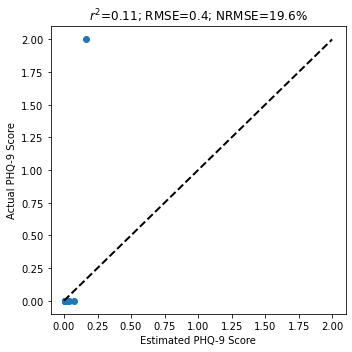

In [8]:
kernel = 1 * RBF() + WhiteKernel()  # Need to choose a kernel for GPR, this is a decent choice

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, optimizer='fmin_l_bfgs_b', normalize_y=True, alpha=0).fit(X_train, y_train)
y_hat = model.predict(X_test)

# Useful metrics for regression model
r2_val = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean(np.square(y_test - y_hat)))
nrmse = rmse / np.ptp(y_test)


# Plot of the model's performance along with the useful metrics (R^2 score, RMSE, & NRMSE)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_hat, y_test)
min_, max_ = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max())
x = np.linspace(min_, max_, 100)  # Perfect estimation line
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('Estimated PHQ-9 Score')
ax.set_ylabel('Actual PHQ-9 Score')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2_val, rmse, nrmse * 100))
fig.tight_layout()